In [ ]:
import gzip
import os
import json
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from textblob import TextBlob
try:
    from tmtoolkit.corpus import Corpus
    from tmtoolkit.preprocess import TMPreproc
    from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
    from tmtoolkit.topicmod.tm_lda import compute_models_parallel
except ModuleNotFoundError:
    !pip install --upgrade pip
    !pip install lda
    !pip install spacy-model-manager
    !spacy-model remove en_core_web_sm
    !pip uninstall -y spacy-model-manager
    !pip uninstall -y spacy
    !pip install spacy==2.3.7
    !python -m spacy download en_core_web_sm
    !pip uninstall -y imgaug
    !pip install "imgaug<0.2.7,>=0.2.5"
    !pip install tmtoolkit==0.10.0
    from tmtoolkit.corpus import Corpus
    from tmtoolkit.preprocess import TMPreproc
    from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words
    from tmtoolkit.topicmod.tm_lda import compute_models_parallel

import pickle
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.topicmod import tm_lda
try:
  from bertopic import BERTopic
except:
  !pip install bertopic[all]
  os.kill(os.getpid(), 9)

In [ ]:
["red", "grey", "gold", "black", "orange"] * 3

['red',
 'grey',
 'gold',
 'black',
 'orange',
 'red',
 'grey',
 'gold',
 'black',
 'orange',
 'red',
 'grey',
 'gold',
 'black',
 'orange']

In [ ]:
#Set plot Style
plt.style.use('seaborn')
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color= ["red", "grey", "gold", "black", "orange"] * 3)

In [ ]:
#set Paths

#Path for all of sub reviews
PATH = "/content/drive/MyDrive/Colab_Notebooks/dtsa5799/data/"
#Path for metadata
meta_data_path = "/content/drive/MyDrive/Colab_Notebooks/dtsa5799/data/metadata.gz"
#Path for all reviews
reviews_path = "/content/drive/MyDrive/Colab_Notebooks/dtsa5799/data/reviews.gz"

# Introduction

"Just do it". A slogan instantly recognized by everyone across the world. Although the company had a slow start, Nike is now a clothing juggernaut. Personally, almost half of my clothing have a the infamous Nike swoosh imprinted on them.

Although they are well known, Nike still faces challenges when developing products for various consumers across the world. In this analysis, we will carry out topic modeling to analyze consumers' thoughts on various products.

# Extracting from the Metadata

First, we would like to gain insight on Nike's customer satisfaction based off of characteristic of the product. The ASINs are unique IDs for each product. We need to collect ASINS based off of characteristics of products we are interested in. The characteristics we can grab from the metadatat are:
  - salesRank: How well a products sells within its respective category. The lower the product, the better it sells.
  - Sales Category: the type of category the product sells in
  - Price: How much an item costs

**Note:** we use the `salesRank` category for our categorical data instead of `categories`. The `categories` key maintain values that may not maintain consistency across different products. Thus, our `salesRank` categories will help organize it better.

In [ ]:
asins =  []
salesRank = {}
categories_main = {}
price = {}
max_saleRank = 0

with gzip.open(meta_data_path) as products:
    for i, product in enumerate(products):
        data = json.loads(product)
        if data.get("salesRank"): #get largest rank in the dataset
          maxRank = max(data.get("salesRank").values())
          if maxRank > max_saleRank:
            max_saleRank = maxRank
        categories = itertools.chain(*data.get("categories", []))
        categories = [c.lower() for c in categories]
        if "nike" in categories:
          asins.append(data["asin"])
          if data.get("salesRank"): 
            for key, value in data.get("salesRank").items():
              if key not in categories_main.keys():
                categories_main[key] = []
              categories_main[key].append(data["asin"]) #put asin in a sales category
              salesRank[data["asin"]] = value #get the sales rank for each asin
          if data.get("price"): #Get price of each asin
            price[data["asin"]] = data.get("price")
          i +=1


        

In [ ]:
categories_main.keys()

dict_keys(['Watches', 'Clothing', 'Shoes', 'Sports &amp; Outdoors', 'Health & Personal Care'])

# Initial Metadata EDA

Lets look at the distributions of the characteristics we collect.


# Sales Rank

Most of Nike's products are within the top 300,000th rank in on Amazon. Considering the largest sales rank from all the products in the dataset is 5,132,858, we can say that Nike products are performing fairly well. In fact, there are some products that are within the top 100,000!

Text(0.5, 0, '')

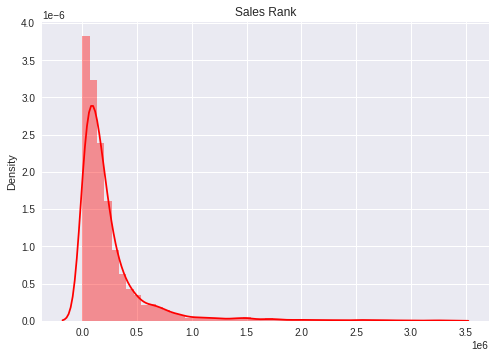

In [ ]:
ranks = np.array(list(salesRank.values()))
#Sales Rank Distribution
plot = sns.distplot(ranks)
plt.title("Sales Rank")
plt.xlabel("")

In [ ]:
max_saleRank #Highest rank from all the products

5132858

Text(0.5, 0, '')

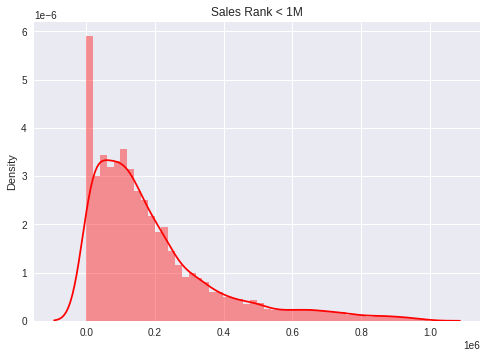

In [ ]:
low_ranks = ranks[ranks < 1000000]
plot = sns.distplot(low_ranks)
plt.title("Sales Rank < 1M")
plt.xlabel("")

# Categories

Nike is a worldwide brand known heavily for their shoes. Thus, there's no surprise that a majority of the product reviews concern shoe apparel. Because our distribution is heavily favored towards shoes, we will compare reviews for shoe products to all other products.

Text(0.5, 1.0, 'Count by Category')

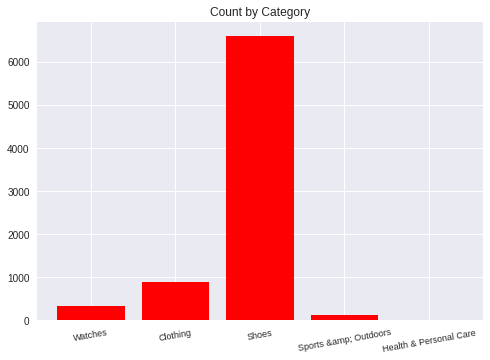

In [ ]:
cat_count = {}

#get count for each category 
for key in categories_main.keys():
  count = len(categories_main[key])
  cat_count[key] = count

keys=list(cat_count.keys())
vals = list(cat_count.values())
plt.bar(keys, vals)
plt.xticks(rotation=10, fontsize=9)
plt.title("Count by Category")

# Price

Because a majority of our reviewws products are shoes, we expect product prices to list anywhere from 50 - 200 dollars. Some of the higher prices may represent products such as watches or outdoor equipment.  

Text(0.5, 0, '')

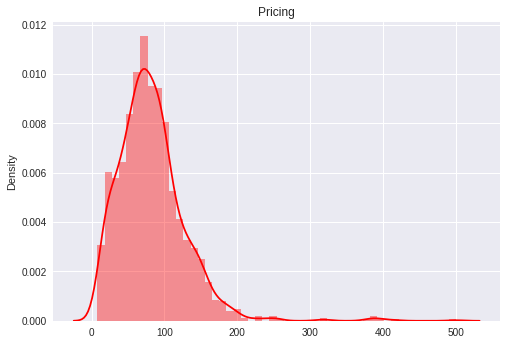

In [ ]:
price_arr = np.array(list(price.values()))
#Sales Rank Distribution
plot = sns.distplot(price_arr)
plt.title("Pricing")
plt.xlabel("")

Text(0.5, 0, '')

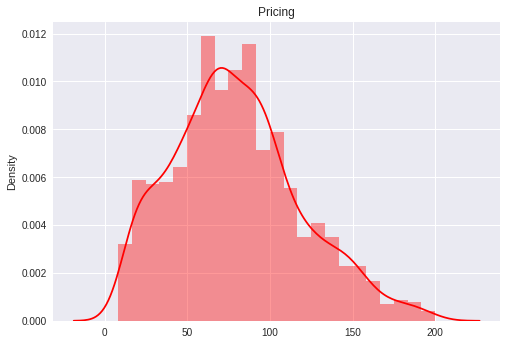

In [ ]:
low_prices = price_arr[price_arr < 200]
plot = sns.distplot(low_prices)
plt.title("Pricing")
plt.xlabel("")

Now that I have the different dictionaries, I will create different datasets to carry out our review analysis. We need to create different datasets to analyze the review in different ways. Thus, the following datasets will be created:
  - List of asins of reviews of the top selling items (salesRank less than 3000)
  - List of asins of the more expensive items
  - List of asins of the least expensive items
    - Will determine 'expensive by if a price is larger than the median
  - List of asins of products belonging to the `shoe` category
  - List of asins belonging to the non-shoe cateogories

We will then use these lists to gather the reviews corresponding to the appropriate ASIN type.

We will then use these ASINs to create the appropriate datasets containing reviews for each characteristic

In [ ]:
median_price = np.median(price_arr)

best_asins = [asin for asin, rank in salesRank.items() if rank <= 3000]
lowPrice_asins = [asin for asin, price in price.items() if price <= median_price]
highPrice_asins = [asin for asin, price in price.items() if price > median_price]
shoe_asins = categories_main['Shoes']
nonshoe_asins = categories_main['Clothing'] + \
  categories_main['Health & Personal Care'] + \
  categories_main['Sports &amp; Outdoors'] + \
  categories_main['Watches']


In [ ]:
print(median_price)

75.0


In [ ]:
def review_write(filename, review_dict, path=PATH):
  """
     Given a dictionary containing reviews, write the reviews out to the specied file

     filename: Name of the file we're writing to
     review_dict: the dictionary to write to the file
     path: the path of the folder where we want to place the reviews
  """
  json.dump(review_dict, open(PATH + filename, 'w'))


In [ ]:
# nike_reviews = []


# with gzip.open(reviews_path) as reviews:
#   for i, review in enumerate(reviews):
#       review = json.loads(review)

#       if review["asin"] in asins:
#         nike_dict = {}
#         nike_dict['reviewID'] = "%s.%s" % (review["asin"], review["reviewerID"])
#         nike_dict['text'] = review['reviewText']
#         nike_dict['asin'] = review['asin']
#         nike_dict['rating'] = review['overall']
#         nike_dict['date'] = review['reviewTime']
#         nike_dict['polarity'] = TextBlob(review['reviewText']).sentiment.polarity
#         nike_reviews.append(nike_dict)

# json.dump(nike_reviews, open(PATH + "NikeReviews.json", "w"))

In [ ]:
df = pd.read_json(PATH + "NikeReviews.json")

In [ ]:
df.head()

,reviewID,text,asin,rating,date,polarity
0,B0000V9K32.ACT5DY536GISV,the colour i received is not blue as shown but...,B0000V9K32,3,2009-07-27,0.066667
1,B0000V9K32.A3BVWMS9I8OH8U,Very cute and is really practical. Fits better...,B0000V9K32,5,2009-12-26,0.395000
2,B0000V9K3W.A5RZS69KSJH00,The watch was exactly what i ordered and I got...,B0000V9K3W,4,2009-10-24,0.002500
3,B0000V9K46.A3F8O512N9UNVM,"This product came promptly and as described, p...",B0000V9K46,5,2008-03-26,0.000000
4,B0000V9KNM.A2EAKTCKFRF7A4,Why isn't Nike making these anymore? I love t...,B0000V9KNM,4,2011-11-16,0.500000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21570 entries, 0 to 21569
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   reviewID  21570 non-null  object        
 1   text      21570 non-null  object        
 2   asin      21570 non-null  object        
 3   rating    21570 non-null  int64         
 4   date      21570 non-null  datetime64[ns]
 5   polarity  21570 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1011.2+ KB


# Collecting Data from Review Characteristics

Next our review dataset contains information that can answer other questions we have.

### What are the common topics among our positively rated products? What about the bad?

- Using the `overall` attribute of the reviews, we can gather the star rating a reviewer gave each product. Using the these ratings, we can dermine whcih topics contribute to a high rating compared to a lower one.


### Among our reviews with negative sentiment, what topics are most talked about? What about positive

- Sentiment is how "feeling" of the text. Does the review indicate the person is happy or unhappy? What are the characteristics of the products with a negative viewpoint. What about a positive?

### What do our frequent reviewers think about our product?

- Frequent reviewers are usually associated with people who are happy with the product. Also, a few critics my leave a few reviews. What do they all think of our products?


### How does the sentiment of our reviews change throughout the years?

- How do the views of our product change throughout the year. What about each year leading until now? What about the ratings?


**Note**: Unlike the `metadata` dataset, the `reviews` dataset doesn't contain a key ID mapped to each review. Therefore, I decided to read the file as a
dataframe. To save memory, I read it by chunks and concatenated them. Last, we created a `reviewID` column for each review.

# Review EDA

Before we begin topic modeling, let's quickly review the distribution of  review ratings and review dates

### Review Counts

- Out of 21,570 reviews, about half of them have a 5 star rating. Buyers LOVE Nike products. Only about 2000 reviewers gave an unsatisfactory rating.
- Summer is the season in which buyers review our products the most. Nike is a brand known for shoes and athletic apparel. Summer is when most people are playing sports. Also, people are outside more. Thus, more people are looking for sneakers, water bottles or any product related to outdoor activity. On the other hand, reviews tend to fall during the fall months. At this time, people are preparing for the winter. Thus, not as many people are active.
- Amazon began as an online marketplace for books in 1994. As the years continued, they began to sell a larger variety of items. The internet became popular in the late '90s; however, many people had to sit at stationary computer. In 2007 the first iPhone released. Afterwards, smartphones became more common. More people had access to the internet at their fingertips. This popularity increase can be shown by the sharp increase of Nike reviews from 2007 and beyond. As we can see, our number of reviews keep increasing; therefore, more people are buying our products.

Text(0.5, 1.0, 'Count of Ratings')

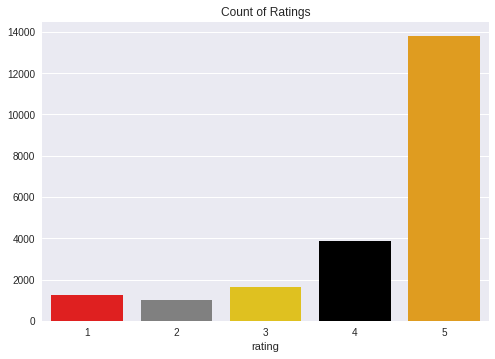

In [ ]:
sns.countplot(x="rating", data=df)
plt.ylabel(None)
plt.title("Count of Ratings")

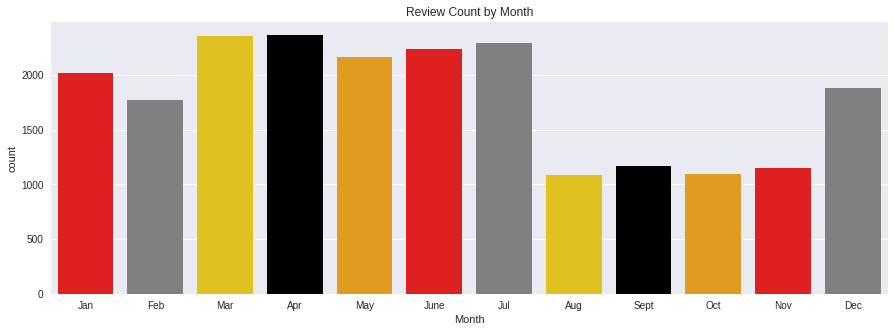

In [ ]:
plt.figure(figsize=(15, 5))
month_num = np.arange(12)
month_name = ["Jan", "Feb", "Mar", "Apr", "May", "June", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]
sns.countplot(x=df["date"].dt.month)
_ = plt.xticks(ticks=month_num, labels=month_name)
_ = plt.xlabel("Month")
_ = plt.title("Review Count by Month")

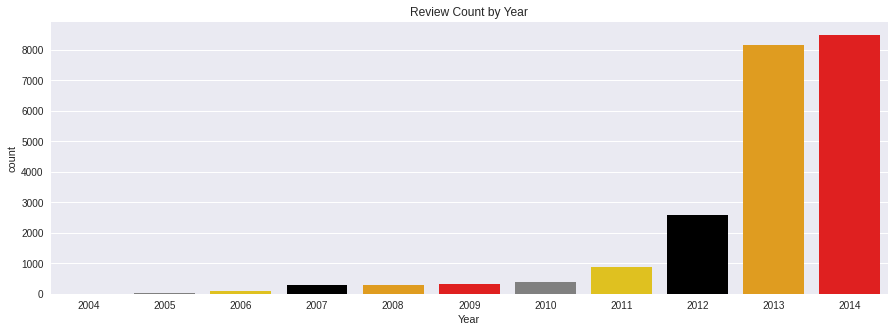

In [ ]:
plt.figure(figsize=(15, 5))
sns.countplot(x=df["date"].dt.year)
_ = plt.xlabel("Year")
_ = plt.title("Review Count by Year")

### Rating by Year
- The ratings of Nike products tend to increase during the winter months. Winter months are when sweatshirts, long sleeve t-shirts and basketball shoes are marketed. It seems we are promoting those products well. However, our amazon ratings are very low during the fall months (August, Septemeber, and October). We will need to compare the two seasons to see what makes the difference. **Note** the standard error for each month are rather wide and overlapping; the differences in rating aren't significant.

- The rating of Nike products have, overall, increased since they were introduced to the Amazon marketplace in 2004. However, because of the small sample size for 2004 and 2005, we cannot confidently state our customers rated higher now compared to 2004 and 2005.  

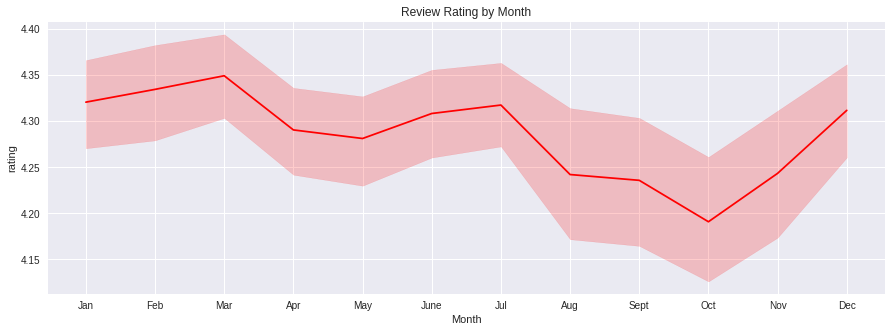

In [ ]:
month_num = np.arange(1,13)
plt.figure(figsize=(15, 5))
sns.lineplot(x=df["date"].dt.month, y=df["rating"])
_ = plt.xticks(ticks=month_num, labels=month_name)
_ = plt.xlabel("Month")
_ = plt.title("Review Rating by Month")

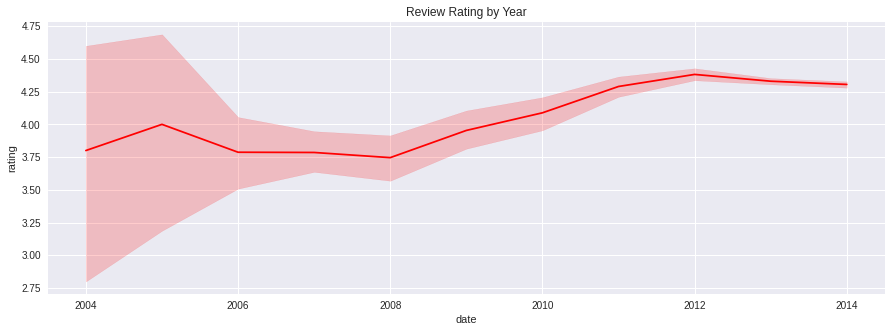

In [ ]:
plt.figure(figsize=(15, 5))
sns.lineplot(x=df["date"].dt.year, y=df["rating"])
_ = plt.title("Review Rating by Year")

In [ ]:
print("Reviews in 2004: %i" % len(df[df["date"].dt.year == 2004]))
print("Reviews in 2005: %i" % len(df[df["date"].dt.year == 2005]))
print("Reviews in 2006: %i" % len(df[df["date"].dt.year == 2006]))
print("Reviews in 2007: %i" % len(df[df["date"].dt.year == 2007]))
print("Reviews in 2008: %i" % len(df[df["date"].dt.year == 2008]))

Reviews in 2004: 5
Reviews in 2005: 16
Reviews in 2006: 108
Reviews in 2007: 284
Reviews in 2008: 295


### Sentiment Analysis by Year or Month

Sentiment analysis is a technique used to see if a text has a positive, negative or neutral tone. It is a great way to use a reviewers words to see how they feel about a product.



From the following plots we can see:

- July, by far, is the month when consumers review more positive. After that, the winter months. Contrastingly, the fall months are when the reviewers have a more negative tone. For the most part, the sentiment timeline matches with how the reviewers rated our products. We will need to compare the different seasons to see what consumers like about products during the different seasons.
- Similar to the reviewer ratings, the sentiment of our product reviews have increased since 2004.

In [ ]:
negativeDf = df[df["polarity"] <= -0.2]
positiveDf = df[df["polarity"] >= 0.2]

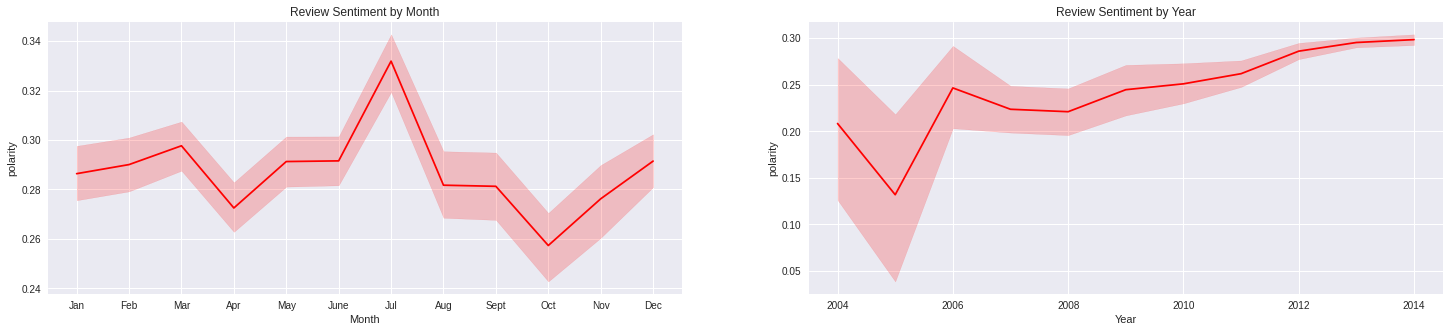

In [224]:
fig, ax = plt.subplots(1,2, figsize=(25, 5))
sns.lineplot(x=df["date"].dt.month, y = df["polarity"], ax= ax[0])
_ = ax[0].set_xticks(month_num)
_= ax[0].set_xticklabels(month_name)
ax[0].set_xlabel("Month")
_= ax[0].set_title("Review Sentiment by Month")

sns.lineplot(x=df["date"].dt.year, y = df["polarity"], ax=ax[1])
ax[1].set_xlabel("Year")
_= ax[1].set_title("Review Sentiment by Year")

## Topic Modeling Preparation

After our EDA, we discovered we need to analyze topic models comparing looking at the following characteristics:
  - Nike reviews as a whole
  - Reviews or our top selling products
  - Low-prices reviews vs high-prices
  - Shoe reviews vs non-show
  - The four different seasons
  - The sentiment of the review

To do this, we need to create different datasets for the different characteristics

In [ ]:
def write_file(filename, listReviews, file_path=PATH):
  with open(PATH + filename, "wb") as corpusfile:
    pickle.dump(listReviews, corpusfile)

In [ ]:
topReviews = list(df[df['asin'].isin(best_asins)]['text'])
write_file("TopReviews.txt", topReviews)

In [ ]:
#Low price reviews
lowPriceReviews = list(df[df['asin'].isin(lowPrice_asins)]['text'])
write_file("InexpensiveReviews.txt", lowPriceReviews)

In [ ]:
#High price reviews
highPriceReviews = list(df[df['asin'].isin(highPrice_asins)]['text'])
write_file("ExpensiveReviews.txt", highPriceReviews)

In [ ]:
#shoes
shoesReviews = list(df[df['asin'].isin(shoe_asins)]['text'])
write_file("ShoeReviews.txt", shoesReviews)

In [ ]:
#nonshoes
nonShoesReviews = list(df[df['asin'].isin(nonshoe_asins)]['text'])
write_file("NonShoeReviews.txt", nonShoesReviews)

In [ ]:
# winter reviews
winterReviews = list(df[df['date'].dt.month.isin([1, 2, 12])]['text'])
write_file("WinterReviews.txt", winterReviews)

In [ ]:
#spring reviews
springReviews = list(df[df['date'].dt.month.isin([3, 4, 5])]['text'])
write_file("SpringReviews.txt", springReviews)

In [ ]:
#summer reviews
summerReviews = list(df[df['date'].dt.month.isin([6, 7, 8])]['text'])
write_file("SummerReviews.txt", summerReviews)

In [ ]:
#fall reviews
fallReviews = list(df[df['date'].dt.month.isin([9, 10, 11])]['text'])
write_file("FallReviews.txt", fallReviews)

In [ ]:
#Negative Sentiment
negativeReviews = list(df[df['polarity'] <= -0.2]['text'])
write_file("NegativeReviews.txt", negativeReviews)

In [ ]:
#Positive Sentiment
positiveReviews = list(df[df['polarity'] >= 0.2]['text'])
write_file("PositiveReviews.txt", positiveReviews)

# Topic Modeling

Now that we have our datasaets, we can begin topic modeling!

With many topic models we need to preprocess out text. This includes lemmatizing, tokenizing, lowercase and any other method to standardize our data. Preprocessing our texts allows us to get more meaning from our documents.

# Modelling with BERT

BERT is a neural-network based technique that uses that behaves differently than other NLP techniques. Many techniques use unilateral direction to try and predict how a word fits in a sentenece. However, BERT looks at the context of the entire sentence to discover a topic. In BERT, word positioning matters while in other processing techniques, it doesn't.

Using BERT, we can easily find the important topics in each of our datasets and how they differ in comparison

# Top Reviews

We can use the similarity matrix to adjust the number of topics we have in our model. 45 seems like a good amoung of topics as not many topics are too similar.

In [ ]:
#set directory for models
model_directory = "/content/drive/MyDrive/Colab_Notebooks/dtsa5799/final/models"

In [ ]:
topReviewsCorpus = Corpus()
for i, a_review in enumerate(topReviews):
  topReviewsCorpus.add_doc(str(i), a_review)
topReviews_preproc = TMPreproc(topReviewsCorpus, language='en')
topReviews_preproc.add_stopwords(['nike'])


<TMPreproc [3549 documents / en]>

In [ ]:
topReviews_preproc.lemmatize()
topReviews_preproc.tokens_to_lowercase()
topReviews_preproc.remove_special_chars_in_tokens()
topReviews_preproc.add_stopwords(['nike'])
topReviews_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
topReviews_preproc.remove_common_tokens(df_threshold=0.8)
topReviews_preproc.remove_uncommon_tokens(df_threshold=0.01)
topReviews = list(topReviews_preproc.texts.values())

In [ ]:
topic_model = BERTopic(language="english", nr_topics=50, n_gram_range=(1,2), )
topics, probs = topic_model.fit_transform(topReviews)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


Looking at our hierarchical plot, we can see that our data fits about 27 topics well. Therefore, we should refit the model with 27 topics.

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_hierarchy()

After we update the number of topics to 27, we can see by the "Term Score Decline per Topic' Graph, the first two terms of each topic describe it the most.

In [ ]:
new_topics, new_probs = topic_model.reduce_topics(topReviews, topics, probs, nr_topics=47)

In [ ]:
# topic_model.save("%s/topReviewsModel" % model_directory)	
topic_model = BERTopic.load("%s/topReviewsModel" % model_directory)	

In [ ]:
freq = topic_model.get_topic_info(); freq.head(8)

,Topic,Count,Name
0,-1,1310,-1_shoe_fit_run_wear
1,0,192,0_sandal_comfortable_wear_buy
2,1,103,1_shoe_great_order_price
3,2,92,2_wide_wide foot_narrow_foot
4,3,85,3_size_small_order_big
5,4,83,4_son_son love_buy son_son wear
6,5,80,5_size_order_half_half size
7,6,74,6_run_run shoe_shoe_free


#### Key Points and Marketing Strategy from Top Reviews
- As we can see from the plot below, sandals are Nike's most sold product. Many people enjoy the comfort of them. 
- Also, customers enjoy the overall quality of our sneakers. However, some shoes have a squeaking problem. More in the popular Air Max's. 
- Our shoe collection has a lack of width diversity
- Also, we shoould not that many parents seem to continue to buy our products for their son. It makes them happy and they enjoy it.
- Lastly, many of our higher selling products are used for running. Specifically, long distances. 


- We need to focus on improving the noise of our shoe. That is the highest complaint. Also, we need to diversify the fit of our shoe. Many consumers are having trouble finding shoes that fit their width. Last, parents tend to buy Nike products for their sons more than daughters. Both genders tend to like our product. Because our shoes are so popular among men, we should have a heavier focus on the women's product. They tend to love our product, however, their wants are overshadowed by the men.

In [ ]:
topic_model.get_topic(8)

[('squeak', 0.07638825997211234),
 ('shoe', 0.01952682918778128),
 ('shoe squeak', 0.017354955285492236),
 ('start squeak', 0.015777232077720214),
 ('back', 0.015741278203903104),
 ('start', 0.01564672318277711),
 ('pair', 0.015233075289345198),
 ('problem', 0.015083843186513877),
 ('air', 0.014286871831296647),
 ('new', 0.012302632388370137)]

In [ ]:
topic_model.visualize_barchart(top_n_topics=9)

# Low Price vs High Price

Next, we would like to see how our Low Prices Products compare to our higher priced products

In [ ]:
# Prepare Low Price
lowPriceCorpus = Corpus()
for i, a_review in enumerate(lowPriceReviews):
  lowPriceCorpus.add_doc(str(i), a_review)
lowPrice_preproc = TMPreproc(lowPriceCorpus, language='en')
lowPrice_preproc.add_stopwords(['nike'])

<TMPreproc [2073 documents / en]>

In [ ]:
#Low Price Preprocess
lowPrice_preproc.lemmatize()
lowPrice_preproc.tokens_to_lowercase()
lowPrice_preproc.remove_special_chars_in_tokens()
lowPrice_preproc.add_stopwords(['nike'])
lowPrice_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
lowPrice_preproc.remove_common_tokens(df_threshold=0.8)
lowPrice_preproc.remove_uncommon_tokens(df_threshold=0.01)
lowPrice = list(lowPrice_preproc.texts.values())

In [ ]:
#Prepare High Price
highPriceCorpus = Corpus()
for i, a_review in enumerate(highPriceReviews):
  highPriceCorpus.add_doc(str(i), a_review)
highPrice_preproc = TMPreproc(highPriceCorpus, language='en')
highPrice_preproc.add_stopwords(['nike'])

<TMPreproc [1380 documents / en]>

In [ ]:
#High Price Preprocess
highPrice_preproc.lemmatize()
highPrice_preproc.tokens_to_lowercase()
highPrice_preproc.remove_special_chars_in_tokens()
highPrice_preproc.add_stopwords(['nike'])
highPrice_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
highPrice_preproc.remove_common_tokens(df_threshold=0.8)
highPrice_preproc.remove_uncommon_tokens(df_threshold=0.01)
highPrice = list(highPrice_preproc.texts.values())

### Low Price Topic Model

In [ ]:
#Fit Low Priced Items
# lowTopicModel = BERTopic(language="english", nr_topics=49, n_gram_range=(1,2))
# lowPriceTopic= lowTopicModel.fit_transform(lowPrice)

In [ ]:
# lowTopicModel.save("%s/lowTopicModel" % model_directory)	
lowTopicModel = BERTopic.load("%s/lowTopicModel" % model_directory)	

In [ ]:
lowTopicModel.visualize_hierarchy()

In [ ]:
freq = lowTopicModel.get_topic_info(); freq.head(8)

,Topic,Count,Name
0,-1,517,-1_shoe_size_pair_wear
1,0,29,0_son son_son_nice son_son okay
2,1,24,1_zumba_shoe zumba_shoe_foot
3,2,52,2_watch_strap_rate_band
4,3,197,3_bag_gym_carry_use
5,4,20,4_sunglass_around_get_pair
6,5,20,5_glass_pair glass_pair_run
7,6,29,6_sandal_slide_foot_pair


### High Price Model

In [ ]:
#Fit High Priced Items
# highTopicModel = BERTopic(language="english", nr_topics=3, n_gram_range=(1,2), )
# highPriceTopics= highTopicModel.fit_transform(highPrice)

In [ ]:
# highTopicModel.save("%s/highTopicModel" % model_directory)	
highTopicModel = BERTopic.load("%s/highTopicModel" % model_directory)	

In [ ]:
highTopicModel.visualize_heatmap()

In [ ]:
freq = highTopicModel.get_topic_info(); freq.head(8)

,Topic,Count,Name
0,0,21,0_son_son son_son okay_son awesome
1,1,131,1_bag_gym_carry_hold
2,2,1228,2_shoe_love_wear_run


In [ ]:
highTopicModel.visualize_hierarchy()

#### Low Price and High Price Key Points and Marketing Strategy

- Overall, our consumers enjoy our low price items. This includes watches, bras, gym bags, sandals (also known as slides) and glasses.
- A known issue are the bra size have uncomfortable fits. In fact, most of our clothing products fit tight.
- For our low priced items. Parents, again, are often buying these products for their children. The sons tend to enjoy the product while the the daughters reaction is a bit convoluted
- Overall, our consumers enjoy our higher priced items. A majority of the recepients are males.
- Customers particularly enjoy the gym bags


- It seems most of our products are loved by males. However, the women are a bit indifferent. Also, many of the clothing is fitting tight. Body positivity is very important in today's society. Expanding the shape and fit of our clothing could attract more people. It would make nike a more inclusive product. Also, filming commercials with women of all body types may help attract more customers. 
-Our high priced items aren't bought as often unless they are shoes. Consumers love our shoes. Thus, focusing on them should not be a strong point right now.

In [ ]:
lowTopicModel.get_topic(14)

[('daughter', 0.16598817354375398),
 ('daughter love', 0.04970914691544827),
 ('bought daughter', 0.027954066893546875),
 ('shoe', 0.022499549896509555),
 ('bought', 0.02192765573953251),
 ('love', 0.021387567485115857),
 ('day', 0.020842362512105115),
 ('run', 0.01986451014770882),
 ('daughter try', 0.019846241522171962),
 ('disappoint daughter', 0.019846241522171962)]

In [ ]:
lowTopicModel.get_topic(7)

[('bra', 0.14803252581864132),
 ('sport', 0.07456629377941262),
 ('sport bra', 0.07029112308776454),
 ('fit', 0.02393466812391846),
 ('bra size', 0.022946344480715166),
 ('band', 0.022420843346667454),
 ('bite', 0.02234964464360149),
 ('overall', 0.021102087915826472),
 ('support', 0.01943976497250971),
 ('size', 0.019212520870663143)]

In [ ]:
lowTopicModel.visualize_barchart(top_n_topics=8)

In [ ]:
highTopicModel.get_topic(2)

[('shoe', 0.06877216643199596),
 ('love', 0.035201603474763546),
 ('wear', 0.03274865337919776),
 ('run', 0.03141972884676585),
 ('like', 0.03137789172348428),
 ('pair', 0.029793687502179842),
 ('great', 0.029108135967079164),
 ('good', 0.028893187965515838),
 ('look', 0.02810594418067169),
 ('fit', 0.027843794130316523)]

In [ ]:
highTopicModel.visualize_barchart()

# Shoes

In [ ]:
# Prepare Shoes
shoesCorpus = Corpus()
for i, a_review in enumerate(shoesReviews):
  shoesCorpus.add_doc(str(i), a_review)
shoes_preproc = TMPreproc(shoesCorpus, language='en')
shoes_preproc.add_stopwords(['nike'])

<TMPreproc [16841 documents / en]>

In [ ]:
#Shoes Preprocess
shoes_preproc.lemmatize()
shoes_preproc.tokens_to_lowercase()
shoes_preproc.remove_special_chars_in_tokens()
shoes_preproc.add_stopwords(['nike', 'shoe', 'sneaker', 'sneakers', 'shoes'])
shoes_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
shoes_preproc.remove_common_tokens(df_threshold=0.8)
shoes_preproc.remove_uncommon_tokens(df_threshold=0.01)
shoesList = list(shoes_preproc.texts.values())

In [ ]:
shoesTopicModel = BERTopic(language="english", nr_topics=50, n_gram_range=(1,2))
shoesTopics, probs = shoesTopicModel.fit_transform(shoesList)

In [ ]:
shoesTopicModel.visualize_hierarchy()

In [ ]:
shoesTopics = shoesTopicModel.reduce_topics(shoesList, shoesTopics, nr_topics=35)

In [ ]:
# shoesTopicModel.save("%s/shoesTopicModel" % model_directory)	
shoesTopicModel = BERTopic.load("%s/shoesTopicModel" % model_directory)	

In [ ]:
shoesTopicModel.visualize_hierarchy()

In [ ]:
freq = shoesTopicModel.get_topic_info(); freq.head(8)

,Topic,Count,Name
0,-1,8609,-1_foot_size_wear_get
1,0,857,0_pair_another_another pair_buy
2,1,534,1_basketball_ankle_play_play basketball
3,2,524,2_run_mile_much_runner
4,3,388,3_fit_great_perfect_fit great
5,4,375,4_bite_little bite_bite small_size
6,5,320,5_air_max_air max_pair air
7,6,266,6_gym_workout_use_great


#### Key Points about Shoe Products

- Many consumers enjoy the coomfortability of our shoes
- Many basketball players buy our shoes for games. The appreciate the strong ankle support
- Along with our basketball players gym goer and casual shoe wearers enjoy the comfortability as well. Many runners believe they perform at their best with our product
- OVerall, consumers enjoy all of our shoe type for various occassion

- Because so many people enjoy the quality, comfortability and performance of our shoes, we could interview them and ask them what they think about them. When other consumers see current, everyday consumers enjoying our product, we should attract more customers. 


In [ ]:
shoesTopicModel.get_topic(16)

[('walk', 0.12191033435587696),
 ('comfortable walk', 0.026168194721745232),
 ('comfortable', 0.026140320454384778),
 ('like walk', 0.024300128728408647),
 ('feel', 0.020251388168991604),
 ('like', 0.020041195070351535),
 ('love', 0.019566487202315713),
 ('great', 0.019559513734782204),
 ('walk around', 0.019325811495476495),
 ('run walk', 0.017742012054098144)]

In [ ]:
shoesTopicModel.visualize_barchart()

#Nonshoe

In [ ]:
# Prepare Nonshoes
nonShoesCorpus = Corpus()
for i, a_review in enumerate(nonShoesReviews):
  nonShoesCorpus.add_doc(str(i), a_review)
nonShoes_preproc = TMPreproc(nonShoesCorpus, language='en')
nonShoes_preproc.add_stopwords(['nike'])

<TMPreproc [4078 documents / en]>

In [ ]:
#nonShoes Preprocess
nonShoes_preproc.lemmatize()
nonShoes_preproc.tokens_to_lowercase()
nonShoes_preproc.remove_special_chars_in_tokens()
nonShoes_preproc.add_stopwords(['nike', 'get'])
nonShoes_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
nonShoes_preproc.remove_common_tokens(df_threshold=0.8)
nonShoes_preproc.remove_uncommon_tokens(df_threshold=0.01)
nonShoesList = list(nonShoes_preproc.texts.values())

In [ ]:
# nonShoesTopicModel = BERTopic(language="english", nr_topics=45, n_gram_range=(1,2))
# nonShoesTopics, probs = nonShoesTopicModel.fit_transform(nonShoesList)

In [ ]:
# nonShoesTopicModel.save("%s/nonShoesTopicModel" % model_directory)	
nonShoesTopicModel = BERTopic.load("%s/nonShoesTopicModel" % model_directory)	

In [ ]:
nonShoesTopicModel.visualize_hierarchy()

In [ ]:
freq = nonShoesTopicModel.get_topic_info(); freq.sort_values("Count", ascending=False)

,Topic,Count,Name
2,1,1093,1_watch_band_time_like
0,-1,771,-1_good_great_bag_love
20,19,485,19_sock_foot_wear_fit
18,17,225,17_shoe_comfortable_run_foot
25,24,181,24_shirt_fit_sleeve_wear
15,14,144,14_bag_gym_gym bag_carry
31,30,101,30_size_small_large_big
26,25,98,25_color_red_blue_black
12,11,95,11_bag_hold_good_use
36,35,56,35_receive_arrive_item_order


In [ ]:
nonShoesTopicModel.get_topic(11)

[('bag', 0.10296131975052246),
 ('hold', 0.029178422786620098),
 ('good', 0.01938514026736311),
 ('use', 0.01871203713748826),
 ('quality', 0.016997798909369418),
 ('much', 0.01680974064293159),
 ('look', 0.016011837735828954),
 ('love', 0.0155090892782697),
 ('bag look', 0.0152697012357858),
 ('bag hold', 0.014626879886182888)]

## NonShoes Key Points
- Enjoy the battery life and the ease of nike watch
- Enjoy the fit and comfortableness of socks
- Enjoy the comfortablness of shirts
- Enjoy the quality of bags. Especially the pocket, it helps with their stuff and has good durability
- Love the variety of colors for different products
  - In particular red, blue and black

As far as a marketing strategy, we can promote ads

In [ ]:
nonShoesTopicModel.visualize_barchart()

#Winter

In [ ]:
#Winter Preprocess
winterCorpus = Corpus()
for i, a_review in enumerate(winterReviews):
  winterCorpus.add_doc(str(i), a_review)
winter_preproc = TMPreproc(winterCorpus, language='en')
winter_preproc.add_stopwords(['nike'])

<TMPreproc [5665 documents / en]>

In [ ]:
winter_preproc.lemmatize()
winter_preproc.tokens_to_lowercase()
winter_preproc.remove_special_chars_in_tokens()
winter_preproc.add_stopwords(['nike', 'get'])
winter_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
winter_preproc.remove_common_tokens(df_threshold=0.8)
winter_preproc.remove_uncommon_tokens(df_threshold=0.01)
winterList = list(winter_preproc.texts.values())

In [ ]:
# winterTopicModel = BERTopic(language="english", nr_topics=55, n_gram_range=(1,2))
# winterTopics, probs = winterTopicModel.fit_transform(winterList)

In [ ]:
# winterTopicModel.save("%s/winterTopicModel" % model_directory)	
winterTopicModel = BERTopic.load("%s/winterTopicModel" % model_directory)	

In [ ]:
winterTopicModel.visualize_hierarchy()

In [ ]:
freq = winterTopicModel.get_topic_info(); freq.head(12)

,Topic,Count,Name
0,-1,2095,-1_shoe_wear_run_pair
1,0,324,0_watch_band_wrist_time
2,1,223,1_sock_foot_fit_pair sock
3,2,157,2_sneaker_great_sneaker ever_love
4,3,154,3_son_son love_shoe son_love
5,4,152,4_color_shoe_love_light
6,5,138,5_comfortable_wear_buy_product
7,6,116,6_bag_gym_hold_use
8,7,111,7_color_look_exactly_picture
9,8,108,8_son_christmas_son love_love


In [ ]:
winterTopicModel.get_topic(10)

[('basketball', 0.10175937835395059),
 ('play', 0.040789665090393286),
 ('basketball shoe', 0.031387469967971995),
 ('play basketball', 0.022643420618291478),
 ('shoe', 0.017503619366455163),
 ('great', 0.014624244345431709),
 ('good', 0.013130383665599803),
 ('perfect', 0.013069132660896826),
 ('game', 0.012563432557592246),
 ('really', 0.011681671693080658)]

### Winter Topic Model Key Points
- Heavier use of nike watched
- Also, socks are more heavily purchased
- More people are enjoying sneakers
- Light colors and red are highly favorable
- Boys tend to love our products as christmas gifts
- Used more heavily for basketball

In [ ]:
winterTopicModel.visualize_barchart(top_n_topics=8)

In [ ]:
winterTopicModel.visualize_term_rank()

# Summer

In [ ]:
#Summer Preprocess
summerCorpus = Corpus()
for i, a_review in enumerate(summerReviews):
  summerCorpus.add_doc(str(i), a_review)
summer_preproc = TMPreproc(summerCorpus, language='en')
summer_preproc.add_stopwords(['nike'])

<TMPreproc [5611 documents / en]>

In [ ]:
summer_preproc.lemmatize()
summer_preproc.tokens_to_lowercase()
summer_preproc.remove_special_chars_in_tokens()
summer_preproc.add_stopwords(['nike', 'get'])
summer_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
summer_preproc.remove_common_tokens(df_threshold=0.8)
summer_preproc.remove_uncommon_tokens(df_threshold=0.01)
summerList = list(summer_preproc.texts.values())

In [ ]:
# summerTopicModel = BERTopic(language="english", nr_topics=45, n_gram_range=(1,2))
# summerTopics, probs = summerTopicModel.fit_transform(summerList)

In [ ]:
# summerTopicModel.save("%s/summerTopicModel" % model_directory)	
summerTopicModel = BERTopic.load("%s/summerTopicModel" % model_directory)	

In [ ]:
summerTopicModel.visualize_hierarchy()

In [ ]:
freq = summerTopicModel.get_topic_info(); freq.head(11)

,Topic,Count,Name
0,-1,2373,-1_shoe_wear_like_look
1,0,259,0_size_order_shoe_small
2,1,225,1_watch_band_face_strap
3,2,198,2_color_love_shoe_white
4,3,156,3_sock_wear_foot_wear sock
5,4,136,4_son_son love_shoe son_love
6,5,133,5_wide_narrow_foot_wide foot
7,6,126,6_sneaker_pair sneaker_sneaker fit_look
8,7,124,7_size_small_size small_big
9,8,112,8_bite_bite small_little bite_size


## Summer Key Points
- Size is a bigger emphasis. Espcially with shoes fitting too small
- Watch is heavily used
- White is the most heavily favored color
- Prefer the thinner socks
- More casusal sneakers are bought

In [ ]:
summerTopicModel.get_topic(9)

[('pair', 0.07945615093443668),
 ('pair pair', 0.027767863320063414),
 ('love', 0.020478781732593314),
 ('buy', 0.019784128627793614),
 ('buy pair', 0.019303181805732064),
 ('year', 0.016795964626366875),
 ('comfortable', 0.01674179134588602),
 ('pair love', 0.01619792027003699),
 ('color', 0.01544610607479057),
 ('pair wear', 0.01457966197558009)]

In [ ]:
summerTopicModel.visualize_barchart()

# Spring

In [ ]:
#Spring Preprocess
springCorpus = Corpus()
for i, a_review in enumerate(springReviews):
  springCorpus.add_doc(str(i), a_review)
spring_preproc = TMPreproc(springCorpus, language='en')
spring_preproc.add_stopwords(['nike'])

<TMPreproc [6887 documents / en]>

In [ ]:
spring_preproc.lemmatize()
spring_preproc.tokens_to_lowercase()
spring_preproc.remove_special_chars_in_tokens()
spring_preproc.add_stopwords(['nike', 'get'])
spring_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
spring_preproc.remove_common_tokens(df_threshold=0.8)
spring_preproc.remove_uncommon_tokens(df_threshold=0.01)
springList = list(spring_preproc.texts.values())

In [ ]:
# springTopicModel = BERTopic(language="english", nr_topics=60, n_gram_range=(1,2))
# springTopics, probs = springTopicModel.fit_transform(springList)

In [ ]:
# springTopicModel.save("%s/springTopicModel" % model_directory)	
springTopicModel = BERTopic.load("%s/springTopicModel" % model_directory)	

In [ ]:
springTopicModel.visualize_hierarchy()

In [ ]:
freq = springTopicModel.get_topic_info(); freq.head(10)

,Topic,Count,Name
0,-1,2431,-1_shoe_pair_much_foot
1,0,281,0_sneaker_pair sneaker_pair_love sneaker
2,1,261,1_son_son love_old son_year old
3,2,256,2_run_run shoe_mile_shoe
4,3,250,3_size_half_half size_small
5,4,230,4_watch_band_time_easy
6,5,182,5_color_shoe_white_red
7,6,165,6_fit_shoe fit_shoe_expect
8,7,165,7_wide_narrow_foot_wide foot
9,8,164,8_sock_sock fit_fit_wear


# Spring Key Points
- More long distance runners are buying shoes. Preparing for Triathalons/ or MArathons
- White and Red are preferred colors


Everything else is pretty much the same as other categories

In [ ]:
springTopicModel.get_topic(9)

[('fit', 0.053446297567295555),
 ('great fit', 0.025848828430884718),
 ('good', 0.02500507828539649),
 ('fits', 0.024792818241787296),
 ('love fit', 0.02454538129704805),
 ('great', 0.024066722788812937),
 ('fit good', 0.019333686188628553),
 ('love', 0.017084653820538243),
 ('nice', 0.016790411879244377),
 ('comfortable', 0.016644865723323483)]

In [ ]:
springTopicModel.visualize_barchart()

# Fall

In [ ]:
#Fall Preprocess
fallCorpus = Corpus()
for i, a_review in enumerate(fallReviews):
  fallCorpus.add_doc(str(i), a_review)
fall_preproc = TMPreproc(fallCorpus, language='en')
fall_preproc.add_stopwords(['nike'])

<TMPreproc [3407 documents / en]>

In [ ]:
fall_preproc.lemmatize()
fall_preproc.tokens_to_lowercase()
fall_preproc.remove_special_chars_in_tokens()
fall_preproc.add_stopwords(['nike', 'get'])
fall_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
fall_preproc.remove_common_tokens(df_threshold=0.8)
fall_preproc.remove_uncommon_tokens(df_threshold=0.01)
fallList = list(fall_preproc.texts.values())

In [ ]:
# fallTopicModel = BERTopic(language="english", nr_topics=45, n_gram_range=(1,2))
# fallTopics, probs = fallTopicModel.fit_transform(fallList)

In [ ]:
# fallTopicModel.save("%s/fallTopicModel" % model_directory)	
fallTopicModel = BERTopic.load("%s/fallTopicModel" % model_directory)	

In [ ]:
fallTopicModel.visualize_hierarchy()

In [ ]:
freq = fallTopicModel.get_topic_info(); freq.sort_values("Count", ascending=False).head(6)

,Topic,Count,Name
0,-1,1247,-1_shoe_wear_foot_run
2,1,279,1_watch_band_wrist_time
13,12,165,12_product_price_item_quality
10,9,143,9_son_son love_school_wear
3,2,125,2_sock_wear_fit_great sock
8,7,99,7_sneaker_love_fit_pair


# Fall
- Parents are going back to school shopping for their kids. Nike is a top choice as their sons love the clothing
  - Both parents and sons enjoy the quality of the clothing, sneakers and watch 

In [ ]:
fallTopicModel.get_topic(7)

[('sneaker', 0.10342313401100414),
 ('love', 0.02674308026375748),
 ('fit', 0.019362612426047945),
 ('pair', 0.017767888303804557),
 ('buy sneaker', 0.016104965529181024),
 ('comfortable', 0.016012366043152874),
 ('color', 0.01590824192660299),
 ('love sneaker', 0.015794797084318583),
 ('good', 0.013861295678395757),
 ('sneaker fit', 0.013804256167869448)]

In [ ]:
fallTopicModel.visualize_barchart()

# Positive Sentiment

In [ ]:
#Positive Sentiment
positiveCorpus = Corpus()
for i, a_review in enumerate(positiveReviews):
  positiveCorpus.add_doc(str(i), a_review)
positive_preproc = TMPreproc(positiveCorpus, language='en')
positive_preproc.add_stopwords(['nike'])

<TMPreproc [13827 documents / en]>

In [ ]:
positive_preproc.lemmatize()
positive_preproc.tokens_to_lowercase()
positive_preproc.remove_special_chars_in_tokens()
positive_preproc.add_stopwords(['nike', 'get'])
positive_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
positive_preproc.remove_common_tokens(df_threshold=0.8)
positive_preproc.remove_uncommon_tokens(df_threshold=0.01)
positiveList = list(positive_preproc.texts.values())

In [ ]:
# positiveTopicModel = BERTopic(language="english", nr_topics=30, n_gram_range=(1,2))
# positiveTopics, probs = positiveTopicModel.fit_transform(positiveList)

In [ ]:
# positiveTopicModel.save("%s/positiveTopicModel" % model_directory)	
positiveTopicModel = BERTopic.load("%s/positiveTopicModel" % model_directory)	

In [ ]:
positiveTopicModel.visualize_hierarchy()

# Positive Sentiment Key Points

- Shoes are comfortable
  - Comfortable to run long distance
- The watch has high quality and easy to use
- All products have high quality
- Basketball shoes are of high quality and have great ankle support
- Customers are willing to buy multiple pairs of shoes die to comfortability and quality
- Both sons and daughters love the product

In [ ]:
positiveTopicModel.get_topic(12)

[('gym', 0.10065698526496612),
 ('workout', 0.039762946037442425),
 ('work', 0.021242957733094064),
 ('great', 0.018878347431606206),
 ('use', 0.017746728362831383),
 ('go gym', 0.017530220667879372),
 ('shoe', 0.017321375858046682),
 ('good', 0.017161802804755245),
 ('gym shoe', 0.016491032170794055),
 ('go', 0.015912945980202)]

In [ ]:
freq = positiveTopicModel.get_topic_info(); freq.head(16)

,Topic,Count,Name
0,-1,5514,-1_shoe_fit_great_good
1,0,860,0_shoe_great_good_comfortable
2,1,580,1_sneaker_love_pair_great
3,2,540,2_run_run shoe_shoe_much
4,3,525,3_son_son love_love_grandson
5,4,500,4_watch_easy_time_use
6,5,414,5_sock_fit_wear_foot
7,6,394,6_product_good_item_time
8,7,324,7_color_light_love_comfortable
9,8,299,8_comfortable_wear_love_good


In [ ]:
positiveTopicModel.visualize_barchart()

# Negative Outlook

In [ ]:
#Negative Sentiment
negativeCorpus = Corpus()
for i, a_review in enumerate(negativeReviews):
  negativeCorpus.add_doc(str(i), a_review)
negative_preproc = TMPreproc(negativeCorpus, language='en')
negative_preproc.add_stopwords(['nike'])

<TMPreproc [472 documents / en]>

In [ ]:
negative_preproc.lemmatize()
negative_preproc.tokens_to_lowercase()
negative_preproc.remove_special_chars_in_tokens()
negative_preproc.add_stopwords(['nike', 'get'])
negative_preproc.clean_tokens(remove_numbers=True, remove_shorter_than=2)
negative_preproc.remove_common_tokens(df_threshold=0.8)
negative_preproc.remove_uncommon_tokens(df_threshold=0.01)
negativeList = list(negative_preproc.texts.values())

In [ ]:
# negativeTopicModel = BERTopic(language="english", nr_topics=45, n_gram_range=(1,2))
# negativeTopics, probs = negativeTopicModel.fit_transform(negativeList)

In [ ]:
# negativeTopicModel.save("%s/negativeTopicModel" % model_directory)	
negativeTopicModel = BERTopic.load("%s/negativeTopicModel" % model_directory)	

In [ ]:
negativeTopicModel.visualize_hierarchy()

In [ ]:
freq = negativeTopicModel.get_topic_info(); freq

,Topic,Count,Name
0,-1,2,-1_case_break_alreadystore_time break
1,0,436,0_shoe_like_wear_size
2,1,34,1_watch_band_battery_buy


In [ ]:
negativeTopicModel.get_topic(0)

[('shoe', 0.08148550384935105),
 ('like', 0.04089318861261198),
 ('wear', 0.04047230295896168),
 ('size', 0.03874172262020476),
 ('buy', 0.03687476491816509),
 ('order', 0.027640351917701207),
 ('return', 0.026530173643552892),
 ('small', 0.026037106968065864),
 ('wrong', 0.02526462550571518),
 ('make', 0.024028123026708852)]

In [ ]:
negativeTopicModel.get_topic(1)

[('watch', 0.2506914499310076),
 ('band', 0.051278976288360076),
 ('battery', 0.04310557596069909),
 ('buy', 0.03876953565594419),
 ('amazon', 0.03637954492727364),
 ('time', 0.035317039514640866),
 ('button', 0.03250462953784773),
 ('give', 0.030853205821754586),
 ('look', 0.030379823536153615),
 ('customer', 0.028488320160200042)]

# Negative Sentiment Points
- Have issues with shoes being the wrong size. Often too msall. Customers have had to return their shoes
- Small amount of customers had issues with the battery life and band size of watched

In [ ]:
negativeTopicModel.visualize_barchart()

# Final Summary

- Nike continues to be a top selling product
- Overall, customers rave about the quality of all our products: watches, shirts, socks and sandals;l however, customers love the shoes most
  - Basketball players love the support of the shoes
    - They are comfortable and provide greate ankle support
  - Long distance runners love the comnfortability of the shoes
-  Among nonshoe products, customers enjoy how easy our products are to work with
  - They love how lightweight our products can be
  - The durability of each of our products is a large advantage
  - Also, the NIKE watch is very easy to use and great for long runs
- Different seasons show different trends among the product reviews
  - During the Winter
    - Basketball shoes are much more popular
    - Also, this is around the time when parents are purchasing NIKE for their kids as Christmas gifts
    - Light colors are preferred but Red is the most popular
  - During the summer
    - Customers care about the fit of the product more
    - More rave about fitting all body types
    - White and Red Are the preferred colors
    - Casual sneakers and sandals are the most desired
    - Thinner socks are more preferred
  - Spring
    - Shoes for distance runners are preferred
    - White and Red are preferred colors
  -  During the fall
    - Large emphasis on buying clothes for kids as they start school
- Both Sons and Daughters love our products
  - However, men tend to received it more as a gift than women.
-Customers have some issues with our products
  - Shoes tend to be too narrow or two wide. They want a wider variety when it comes to foot width
  - Shoes also tend to have a squeaking issue
    - Most common shoes to do this are the air maxs
  - Customers commonly have issues with the size of the shoe and have to return them
  - A few customers are having battery issues with their NIKE watch
  - Nike lacks clothing products for body diversity
    - This is very common for bras

# Marketing Strategies

- Market Towards Women More
  - Men are repeat customers. They love our quality and typically come back. Whether they buy the products themselves or their loved ones do
  - Women Overshadowed by Men often. We can see that women love our shoes, but men typically dominate our market. Thus, creating and advertising more women-friendly products can guide them to us
  - Also, women struggle with fitting our clothes. Women come in a variety of shapes and sizes. We need to strategically develop products that can help our customers of all shapes and sizes
- Advertise heavily with basketball during the winter
  - Basketball players love the look, quality comfortableness and support of our shoes
  - Advertising towards basketball in the winter can increase our sales
  - This is also around Christmas when parents are buying gifts for their kids
  - Profitable discounts may work in our favor here
- During the spring, focus on distance runners more.
  - Around the time when people start preparing for marathons
  - Also, many people are preparing to get fit for the summer
  - Lighter clothing is much popular
- We need to improve the sound of our shoes
  - there are many complaints regarding the sound of our shoe
  - Once fixed, we can advertise towards having a new and improved shoe
  
